In [1]:
import math
from math import log, sqrt, exp
import numpy as np
import scipy.stats as si
from scipy.stats import norm
from scipy.optimize import brentq
from scipy.optimize import least_squares
from scipy.optimize import fmin
from matplotlib import pyplot as plt
from matplotlib.widgets import Slider, Button, RadioButtons
import plotly.graph_objects as go
import pandas as pd
import datetime as dt
import warnings

In [2]:
# Settings the warnings to be ignored 
warnings.filterwarnings('ignore') 

%matplotlib ipympl

In [3]:
SPX_spot=3662.45
SPY_spot=366.02

In [4]:
SPX_df = pd.read_csv("SPX_options.csv")
SPY_df = pd.read_csv("SPY_options.csv")
Rates_df = pd.read_csv("zero_rates_20201201.csv")

In [5]:
SPX_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2072 entries, 0 to 2071
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   date            2072 non-null   int64  
 1   exdate          2072 non-null   int64  
 2   cp_flag         2072 non-null   object 
 3   strike_price    2072 non-null   int64  
 4   best_bid        2072 non-null   float64
 5   best_offer      2072 non-null   float64
 6   exercise_style  2072 non-null   object 
dtypes: float64(2), int64(3), object(2)
memory usage: 113.4+ KB


In [6]:
SPY_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400 entries, 0 to 1399
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   date            1400 non-null   int64  
 1   exdate          1400 non-null   int64  
 2   cp_flag         1400 non-null   object 
 3   strike_price    1400 non-null   int64  
 4   best_bid        1400 non-null   float64
 5   best_offer      1400 non-null   float64
 6   exercise_style  1400 non-null   object 
dtypes: float64(2), int64(3), object(2)
memory usage: 76.7+ KB


In [7]:
Rates_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    45 non-null     int64  
 1   days    45 non-null     int64  
 2   rate    45 non-null     float64
dtypes: float64(1), int64(2)
memory usage: 1.2 KB


#### Note that there are only 3 unique expiry dates and all the data is as of 1 day (there is no time series)

In [8]:
SPX_df["exdate"].value_counts()

exdate
20201218    822
20210115    738
20210219    512
Name: count, dtype: int64

In [9]:
SPY_df["exdate"].value_counts()

exdate
20210115    556
20201218    510
20210219    334
Name: count, dtype: int64

In [10]:
SPX_df["date"].value_counts()

date
20201201    2072
Name: count, dtype: int64

In [11]:
SPY_df["date"].value_counts()

date
20201201    1400
Name: count, dtype: int64

# Data Cleaning

In [12]:
# These look to be annualized rates

Rates_df

,date,days,rate
0,20201201,7,0.102280
1,20201201,13,0.114128
2,20201201,49,0.216480
3,20201201,77,0.220707
4,20201201,104,0.219996
5,20201201,139,0.218208
6,20201201,167,0.216468
7,20201201,195,0.215228
8,20201201,286,0.212862
9,20201201,377,0.214085


In [13]:
Rates_df["date"] = pd.to_datetime(Rates_df["date"], format="%Y%m%d")

In [14]:
Rates_df["rate_decimal"] = Rates_df["rate"] / 100

In [15]:
Rates_df = Rates_df.drop(["date"], axis=1)

Rates_df.set_index("days", inplace=True)

Rates_df = Rates_df.reindex(np.arange(Rates_df.index.min(), Rates_df.index.max() + 1))

# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.interpolate.html
Rates_df = Rates_df.interpolate(method="linear")

In [16]:
Rates_df

,rate,rate_decimal
days,,
7,0.102280,0.001023
8,0.104255,0.001043
9,0.106229,0.001062
10,0.108204,0.001082
11,0.110179,0.001102
...,...,...
3572,0.955703,0.009557
3573,0.955906,0.009559
3574,0.956109,0.009561


### Prepare data for SPX

In [17]:
SPX_df

,date,exdate,cp_flag,strike_price,best_bid,best_offer,exercise_style
0,20201201,20201218,C,100000,3547.6,3570.5,E
1,20201201,20201218,C,200000,3447.6,3470.5,E
2,20201201,20201218,C,300000,3347.7,3370.6,E
3,20201201,20201218,C,400000,3247.7,3270.6,E
4,20201201,20201218,C,500000,3147.7,3170.6,E
...,...,...,...,...,...,...,...
2067,20201201,20210219,P,5000000,1333.1,1350.5,E
2068,20201201,20210219,P,5100000,1431.8,1454.7,E
2069,20201201,20210219,P,5200000,1531.7,1554.6,E
2070,20201201,20210219,P,5300000,1631.5,1654.4,E


In [18]:
SPX_df["date"] = pd.to_datetime(SPX_df["date"], format="%Y%m%d")
SPX_df["exdate"] = pd.to_datetime(SPX_df["exdate"], format="%Y%m%d")

In [19]:
SPX_df["days_to_expiry"] = (SPX_df["exdate"] - SPX_df["date"]) / pd.Timedelta(days=1)
SPX_df["years_to_expiry"] = SPX_df["days_to_expiry"] / 365

In [20]:
SPX_df["mid_price"] = 0.5 * (SPX_df["best_bid"] + SPX_df["best_offer"])

In [21]:
SPX_df["strike_price"] = SPX_df["strike_price"] / 1000

In [22]:
SPX_df["options_type"] = SPX_df["cp_flag"].map(lambda x: "call" if x == "C" else "put")

In [23]:
SPX_df=SPX_df.merge(Rates_df,
                    left_on="days_to_expiry",
                    right_index=True)

In [24]:
SPX_df

,date,exdate,cp_flag,strike_price,best_bid,best_offer,exercise_style,days_to_expiry,years_to_expiry,mid_price,options_type,rate,rate_decimal
0,2020-12-01,2020-12-18,C,100.0,3547.6,3570.5,E,17.0,0.046575,3559.05,call,0.125500,0.001255
1,2020-12-01,2020-12-18,C,200.0,3447.6,3470.5,E,17.0,0.046575,3459.05,call,0.125500,0.001255
2,2020-12-01,2020-12-18,C,300.0,3347.7,3370.6,E,17.0,0.046575,3359.15,call,0.125500,0.001255
3,2020-12-01,2020-12-18,C,400.0,3247.7,3270.6,E,17.0,0.046575,3259.15,call,0.125500,0.001255
4,2020-12-01,2020-12-18,C,500.0,3147.7,3170.6,E,17.0,0.046575,3159.15,call,0.125500,0.001255
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2067,2020-12-01,2021-02-19,P,5000.0,1333.1,1350.5,E,80.0,0.219178,1341.80,put,0.220628,0.002206
2068,2020-12-01,2021-02-19,P,5100.0,1431.8,1454.7,E,80.0,0.219178,1443.25,put,0.220628,0.002206
2069,2020-12-01,2021-02-19,P,5200.0,1531.7,1554.6,E,80.0,0.219178,1543.15,put,0.220628,0.002206
2070,2020-12-01,2021-02-19,P,5300.0,1631.5,1654.4,E,80.0,0.219178,1642.95,put,0.220628,0.002206


### Prepare data for SPY

In [25]:
SPY_df

,date,exdate,cp_flag,strike_price,best_bid,best_offer,exercise_style
0,20201201,20201218,C,25000,340.74,341.20,A
1,20201201,20201218,C,50000,315.75,316.21,A
2,20201201,20201218,C,75000,290.75,291.21,A
3,20201201,20201218,C,80000,285.75,286.21,A
4,20201201,20201218,C,85000,280.75,281.21,A
...,...,...,...,...,...,...,...
1395,20201201,20210219,P,480000,115.03,115.93,A
1396,20201201,20210219,P,485000,120.08,120.92,A
1397,20201201,20210219,P,490000,125.07,125.92,A
1398,20201201,20210219,P,495000,129.98,130.92,A


In [26]:
SPY_df["date"] = pd.to_datetime(SPY_df["date"], format="%Y%m%d")
SPY_df["exdate"] = pd.to_datetime(SPY_df["exdate"], format="%Y%m%d")

In [27]:
SPY_df["days_to_expiry"] = (SPY_df["exdate"] - SPY_df["date"]) / pd.Timedelta(days=1)
SPY_df["years_to_expiry"] = SPY_df["days_to_expiry"] / 365

In [28]:
SPY_df["mid_price"] = 0.5 * (SPY_df["best_bid"] + SPY_df["best_offer"])

In [29]:
SPY_df["strike_price"] = SPY_df["strike_price"] / 1000

In [30]:
SPY_df["options_type"] = SPY_df["cp_flag"].map(lambda x: "call" if x == "C" else "put")

In [31]:
SPY_df

,date,exdate,cp_flag,strike_price,best_bid,best_offer,exercise_style,days_to_expiry,years_to_expiry,mid_price,options_type
0,2020-12-01,2020-12-18,C,25.0,340.74,341.20,A,17.0,0.046575,340.970,call
1,2020-12-01,2020-12-18,C,50.0,315.75,316.21,A,17.0,0.046575,315.980,call
2,2020-12-01,2020-12-18,C,75.0,290.75,291.21,A,17.0,0.046575,290.980,call
3,2020-12-01,2020-12-18,C,80.0,285.75,286.21,A,17.0,0.046575,285.980,call
4,2020-12-01,2020-12-18,C,85.0,280.75,281.21,A,17.0,0.046575,280.980,call
...,...,...,...,...,...,...,...,...,...,...,...
1395,2020-12-01,2021-02-19,P,480.0,115.03,115.93,A,80.0,0.219178,115.480,put
1396,2020-12-01,2021-02-19,P,485.0,120.08,120.92,A,80.0,0.219178,120.500,put
1397,2020-12-01,2021-02-19,P,490.0,125.07,125.92,A,80.0,0.219178,125.495,put
1398,2020-12-01,2021-02-19,P,495.0,129.98,130.92,A,80.0,0.219178,130.450,put


In [32]:
SPY_df=SPY_df.merge(Rates_df,
                    left_on="days_to_expiry",
                    right_index=True)

In [33]:
SPY_df

,date,exdate,cp_flag,strike_price,best_bid,best_offer,exercise_style,days_to_expiry,years_to_expiry,mid_price,options_type,rate,rate_decimal
0,2020-12-01,2020-12-18,C,25.0,340.74,341.20,A,17.0,0.046575,340.970,call,0.125500,0.001255
1,2020-12-01,2020-12-18,C,50.0,315.75,316.21,A,17.0,0.046575,315.980,call,0.125500,0.001255
2,2020-12-01,2020-12-18,C,75.0,290.75,291.21,A,17.0,0.046575,290.980,call,0.125500,0.001255
3,2020-12-01,2020-12-18,C,80.0,285.75,286.21,A,17.0,0.046575,285.980,call,0.125500,0.001255
4,2020-12-01,2020-12-18,C,85.0,280.75,281.21,A,17.0,0.046575,280.980,call,0.125500,0.001255
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,2020-12-01,2021-02-19,P,480.0,115.03,115.93,A,80.0,0.219178,115.480,put,0.220628,0.002206
1396,2020-12-01,2021-02-19,P,485.0,120.08,120.92,A,80.0,0.219178,120.500,put,0.220628,0.002206
1397,2020-12-01,2021-02-19,P,490.0,125.07,125.92,A,80.0,0.219178,125.495,put,0.220628,0.002206
1398,2020-12-01,2021-02-19,P,495.0,129.98,130.92,A,80.0,0.219178,130.450,put,0.220628,0.002206


# Calculate implied volatility using brentq

Brent's method requires an objective function that changes signs between the two endpoints of the interval.

https://stackoverflow.com/questions/61289020/fast-implied-volatility-calculation-in-python

https://medium.com/@polanitzer/implied-volatility-in-python-compute-the-volatilities-implied-by-option-prices-observed-in-the-e2085c184270

https://github.com/jieren123/stock-implied-volatility-using-root-finding/blob/master/Brent.py

In [34]:
def BlackScholesLognormalCall(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)

In [35]:
def BlackScholesLognormalPut(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return K*np.exp(-r*T)*norm.cdf(-d2) - S*norm.cdf(-d1)

In [36]:
def impliedVolatility(S, K, r, price, T, payoff):
    try:
        if (payoff.lower() == 'call'):
            impliedVol = brentq(lambda x: price -
                                BlackScholesLognormalCall(S, K, r, x, T),
                                1e-12, 10.0)
        elif (payoff.lower() == 'put'):
            impliedVol = brentq(lambda x: price -
                                BlackScholesLognormalPut(S, K, r, x, T),
                                1e-12, 10.0)
        else:
            raise NameError('Payoff type not recognized')
    except Exception:
        impliedVol = np.nan

    return impliedVol

In [37]:
def compute_implied_volatility(df_options, current_price):
    Spot_price = current_price
    unique_days_to_expiry = df_options["days_to_expiry"].unique()
    volatility_by_date = {}
    for day_to_expire in unique_days_to_expiry:
        df_filtered = df_options[
            df_options["days_to_expiry"] == day_to_expire
        ].reset_index(drop=True)
        
        
        df_filtered["implied_vol"] = df_filtered.apply(
            lambda x: impliedVolatility(
                Spot_price,
                x["strike_price"],
                x['rate_decimal'],
                x["mid_price"],
                x["years_to_expiry"],
                x["options_type"],
            ),
            axis=1,
        )
        df_filtered.dropna(inplace=True)

        df_call = df_filtered[df_filtered["options_type"] == "call"]
        df_put = df_filtered[df_filtered["options_type"] == "put"]
        strikes = df_put["strike_price"].values
        implied_vols = []
        options_type = []
        discount_rate =[]
        options_price=[]
        for K in strikes:
            if Spot_price < K:
                options_type.append("call")
                discount_rate.append(
                    df_call[df_call["strike_price"] == K]["rate_decimal"].values[0]
                )
                options_price.append(
                    df_call[df_call["strike_price"] == K]["mid_price"].values[0]
                )
                implied_vols.append(
                    df_call[df_call["strike_price"] == K]["implied_vol"].values[0]
                )
            else:
                options_type.append("put")
                discount_rate.append(
                    df_put[df_put["strike_price"] == K]["rate_decimal"].values[0]
                )
                options_price.append(
                    df_put[df_put["strike_price"] == K]["mid_price"].values[0]
                )
                implied_vols.append(
                    df_put[df_put["strike_price"] == K]["implied_vol"].values[0]
                )
        df_implied_vols = pd.DataFrame(
            {
                "strike": strikes,
                "impliedvol": implied_vols,
                "options_type": options_type,
                "discount_rate": discount_rate,
                "options_price": options_price
            }
        )
        volatility_by_date[str(int(day_to_expire))] = df_implied_vols
    return volatility_by_date

### SPX implied vol

In [38]:
implied_vol_dict_spx = compute_implied_volatility(SPX_df, SPX_spot)

In [39]:
implied_vol_dict_spx

{'17':      strike  impliedvol options_type  discount_rate  options_price
 0     100.0    4.685324          put       0.001255          0.025
 1     200.0    3.741195          put       0.001255          0.025
 2     300.0    3.204791          put       0.001255          0.025
 3     400.0    2.830325          put       0.001255          0.025
 4     500.0    2.542973          put       0.001255          0.025
 ..      ...         ...          ...            ...            ...
 406  5000.0    0.436196         call       0.001255          0.050
 407  5100.0    0.461523         call       0.001255          0.050
 408  5200.0    0.486234         call       0.001255          0.050
 409  5300.0    0.486495         call       0.001255          0.025
 410  5400.0    0.533932         call       0.001255          0.050
 
 [411 rows x 5 columns],
 '45':      strike  impliedvol options_type  discount_rate  options_price
 0     100.0    3.020479          put       0.002051          0.050
 1     20

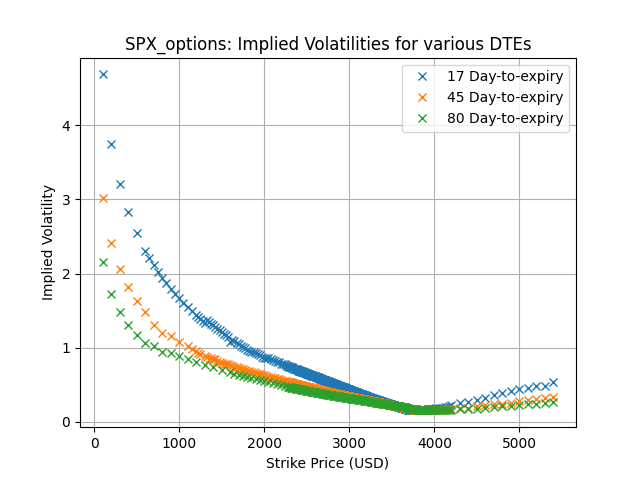

In [40]:
plt.plot()

plt.title("SPX_options: Implied Volatilities for various DTEs")
for day_to_expiry, df_vol in implied_vol_dict_spx.items():
    plt.plot(
        df_vol["strike"],
        df_vol["impliedvol"],
        "x",
        label="{} Day-to-expiry".format(day_to_expiry),
    )

plt.grid()
plt.xlabel("Strike Price (USD)")
plt.ylabel("Implied Volatility")
plt.legend()

In [41]:
# Create a plotly figure
fig = go.Figure()

# Loop through each day-to-expiry and plot the implied volatility
for day_to_expiry, df_vol in implied_vol_dict_spx.items():
    fig.add_trace(go.Scatter(
        x=df_vol["strike"],
        y=df_vol["impliedvol"],
        mode="markers",  # Use markers to match "x" style
        name=f"{day_to_expiry} Day-to-expiry"
    ))

# Customize layout
fig.update_layout(
    title="SPX_options: Implied Volatilities for various DTEs",
    xaxis_title="Strike Price (USD)",
    yaxis_title="Implied Volatility",
    showlegend=True,
    height=600, width=900,
)

# Adding grid lines
fig.update_xaxes(showgrid=True)
fig.update_yaxes(showgrid=True)

# Show plot
fig.show()

### SPY implied vol

In [42]:
implied_vol_dict_spy = compute_implied_volatility(SPY_df, SPY_spot)

In [43]:
implied_vol_dict_spy

{'17':      strike  impliedvol options_type  discount_rate  options_price
 0      25.0    3.606730          put       0.001255          0.005
 1      50.0    2.660929          put       0.001255          0.005
 2      75.0    2.120640          put       0.001255          0.005
 3      80.0    2.035340          put       0.001255          0.005
 4      85.0    1.955363          put       0.001255          0.005
 ..      ...         ...          ...            ...            ...
 250   495.0    0.424099         call       0.001255          0.005
 251   500.0    0.437003         call       0.001255          0.005
 252   505.0    0.449745         call       0.001255          0.005
 253   510.0    0.462328         call       0.001255          0.005
 254   515.0    0.474756         call       0.001255          0.005
 
 [255 rows x 5 columns],
 '45':      strike  impliedvol options_type  discount_rate  options_price
 0      25.0    2.216993          put       0.002051          0.005
 1      3

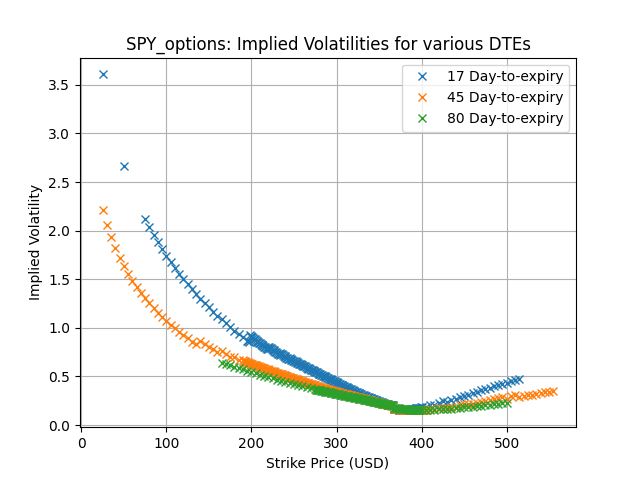

In [44]:
plt.figure()

plt.title("SPY_options: Implied Volatilities for various DTEs")
for day_to_expiry, df_vol in implied_vol_dict_spy.items():
    plt.plot(
        df_vol["strike"],
        df_vol["impliedvol"],
        "x",
        label="{} Day-to-expiry".format(day_to_expiry),
    )

plt.grid()
plt.xlabel("Strike Price (USD)")
plt.ylabel("Implied Volatility")
plt.legend()

In [45]:
# Create a plotly figure
fig = go.Figure()

# Loop through each day-to-expiry and plot the implied volatility
for day_to_expiry, df_vol in implied_vol_dict_spy.items():
    fig.add_trace(go.Scatter(
        x=df_vol["strike"],
        y=df_vol["impliedvol"],
        mode="markers",  # Use markers to match "x" style
        name=f"{day_to_expiry} Day-to-expiry"
    ))

# Customize layout
fig.update_layout(
    title="SPY_options: Implied Volatilities for various DTEs",
    xaxis_title="Strike Price (USD)",
    yaxis_title="Implied Volatility",
    showlegend=True,
    height=600, width=900,
)

# Adding grid lines
fig.update_xaxes(showgrid=True)
fig.update_yaxes(showgrid=True)

# Show plot
fig.show()

# Displaced Diffusion Calibration

In [46]:
def DisplacedDiffusionCall(S0:float, 
                           K:float, 
                           r:float, 
                           sigma:float, 
                           T:float,
                           beta:float):
    
    """
    Calculate the value of a call option under the displaced diffusion model.
    
    Parameters:
    S0 : float  - Spot price of the underlying asset
    K  : float  - Strike price
    r  : float  - Risk-free interest rate
    sigma : float  - Volatility of the underlying asset
    T  : float  - Time to maturity (in years)
    beta : float - Displacement parameter (0 < beta <= 1)
    
    Returns:
    float - The value of the displaced diffusion call option
    """
    
    F0 = np.exp(r*T)*S0
    
    # From Session 6, slide 14
    DD_FO=F0/beta
    
    DD_K=K+((1-beta)/beta)*F0
    
    DD_sigma=sigma*beta
    
    # Refer to last line in Session 5, slide 16. This is NOT the same d1 used in BlackScholes
    d1 = (np.log(DD_FO/DD_K) + 0.5 * (DD_sigma**2) * T) / (DD_sigma*np.sqrt(T))
    
    d2 = d1 - DD_sigma * np.sqrt(T)
    
    # Last line in Session 5, slide 16
    value = np.exp(-r*T) * (DD_FO * norm.cdf(d1) - DD_K * norm.cdf(d2))
    
    return value

In [47]:
def DisplacedDiffusionPut(S0:float, 
                          K:float, 
                          r:float, 
                          sigma:float, 
                          T:float,
                          beta:float):
    
    """
    Calculate the value of a put option under the displaced diffusion model.

    Parameters:
    S0 : float  - Spot price of the underlying asset
    K  : float  - Strike price
    r  : float  - Risk-free interest rate
    sigma : float  - Volatility of the underlying asset
    T  : float  - Time to maturity (in years)
    beta : float - Displacement parameter (0 < beta <= 1)

    Returns:
    float - The value of the displaced diffusion put option
    """
    
    F0 = np.exp(r*T)*S0
    
    # From Session 6, slide 14
    DD_F0=F0/beta
    
    DD_K=K+((1-beta)/beta)*F0
    
    DD_sigma=sigma*beta
    
    # Refer to last line in Session 5, slide 16. This is NOT the same d1 used in BlackScholes
    d1 = (np.log(DD_F0/DD_K) + 0.5 * (DD_sigma**2) * T) / (DD_sigma*np.sqrt(T))
    
    d2 = d1 - DD_sigma * np.sqrt(T)
    
    # Last line in Session 5,slide 16, but order is flipped, just like BlackScholes put
    value = np.exp(-r*T) * (DD_K * norm.cdf(-d2) - DD_F0 * norm.cdf(-d1))
    
    return value

In [48]:
def calculate_DD_vol_err(x, 
                         strikes, 
                         vols, 
                         S, 
                         r, 
                         sigma, 
                         T, 
                         options_type):
    
    err = 0.0
    for i, vol in enumerate(vols):
        if options_type[i] == "call":
            price = DisplacedDiffusionCall(S0=S, 
                                           K=strikes[i], 
                                           r=r, 
                                           sigma=sigma, 
                                           T=T, 
                                           beta=x[0])
        else:
            price = DisplacedDiffusionPut(S0=S, 
                                           K=strikes[i], 
                                           r=r, 
                                           sigma=sigma, 
                                           T=T, 
                                           beta=x[0])
            
        implied_vol = impliedVolatility(S = S, 
                                        K = strikes[i], 
                                        r = r, 
                                        price = price, 
                                        T = T, 
                                        payoff = options_type[i])
        if not np.isfinite(implied_vol):
            print(f"Invalid implied volatility at strike {strikes[i]}, option type {options_type[i]}")
        
        err += (vol - implied_vol) ** 2
    return err

### Displaced Diffusion calibration for SPX

In [49]:
implied_vol_dict_spx.items()

dict_items([('17',      strike  impliedvol options_type  discount_rate  options_price
0     100.0    4.685324          put       0.001255          0.025
1     200.0    3.741195          put       0.001255          0.025
2     300.0    3.204791          put       0.001255          0.025
3     400.0    2.830325          put       0.001255          0.025
4     500.0    2.542973          put       0.001255          0.025
..      ...         ...          ...            ...            ...
406  5000.0    0.436196         call       0.001255          0.050
407  5100.0    0.461523         call       0.001255          0.050
408  5200.0    0.486234         call       0.001255          0.050
409  5300.0    0.486495         call       0.001255          0.025
410  5400.0    0.533932         call       0.001255          0.050

[411 rows x 5 columns]), ('45',      strike  impliedvol options_type  discount_rate  options_price
0     100.0    3.020479          put       0.002051          0.050
1     200.

In [50]:
implied_vol_dict_spx

{'17':      strike  impliedvol options_type  discount_rate  options_price
 0     100.0    4.685324          put       0.001255          0.025
 1     200.0    3.741195          put       0.001255          0.025
 2     300.0    3.204791          put       0.001255          0.025
 3     400.0    2.830325          put       0.001255          0.025
 4     500.0    2.542973          put       0.001255          0.025
 ..      ...         ...          ...            ...            ...
 406  5000.0    0.436196         call       0.001255          0.050
 407  5100.0    0.461523         call       0.001255          0.050
 408  5200.0    0.486234         call       0.001255          0.050
 409  5300.0    0.486495         call       0.001255          0.025
 410  5400.0    0.533932         call       0.001255          0.050
 
 [411 rows x 5 columns],
 '45':      strike  impliedvol options_type  discount_rate  options_price
 0     100.0    3.020479          put       0.002051          0.050
 1     20

In [51]:
SPX_DD_params_by_date = {}

for day_to_expiry, df_vol in implied_vol_dict_spx.items():
    T = float(day_to_expiry) / 365
    spot = SPX_spot
    
    # https://numpy.org/doc/stable/reference/generated/numpy.interp.html
    # This is to estimate the implied volatility (sigma) at the current spot price of the underlying asset (SPX_spot) based on 
    # a known set of implied volatilities (df_vol["impliedvol"]) across different strike prices (df_vol["strike"]). 
    # This serves as an initial estimate of the volatility to be used in further calculations or calibration of the displaced diffusion model. 
    # By interpolating at the SPX_spot level, the code gets a volatility estimate that reflects the market’s current view 
    # of implied volatility near the current price level, which may improve calibration accuracy.
    sigma = np.interp(spot, df_vol["strike"], df_vol["impliedvol"])

    initial_guess = [0.50]  # beta
    res = least_squares(
        lambda x: calculate_DD_vol_err(
                                    x = x,
                                    strikes = df_vol["strike"],
                                    vols = df_vol["impliedvol"],
                                    S = spot,
                                    r = df_vol["discount_rate"][0],
                                    sigma = sigma,
                                    T = T,
                                    options_type = df_vol["options_type"],
                                ),
                                initial_guess,
                                bounds=(0, 1),
    )
    SPX_DD_params_by_date[day_to_expiry] = {"sigma": sigma, "beta": res.x[0]}
    
SPX_DD_params_by_date

Invalid implied volatility at strike 100.0, option type put
Invalid implied volatility at strike 1000.0, option type put
Invalid implied volatility at strike 1100.0, option type put
Invalid implied volatility at strike 1150.0, option type put
Invalid implied volatility at strike 1475.0, option type put
Invalid implied volatility at strike 300.0, option type put
Invalid implied volatility at strike 1000.0, option type put
Invalid implied volatility at strike 1600.0, option type put


{'17': {'sigma': 0.17448532472572187, 'beta': 1.2077341209856357e-06},
 '45': {'sigma': 0.1849096526276905, 'beta': 4.4790761846028e-07},
 '80': {'sigma': 0.19374721854522414, 'beta': 6.304146518532905e-07}}

In [52]:
SPX_DD_params_by_date

{'17': {'sigma': 0.17448532472572187, 'beta': 1.2077341209856357e-06},
 '45': {'sigma': 0.1849096526276905, 'beta': 4.4790761846028e-07},
 '80': {'sigma': 0.19374721854522414, 'beta': 6.304146518532905e-07}}

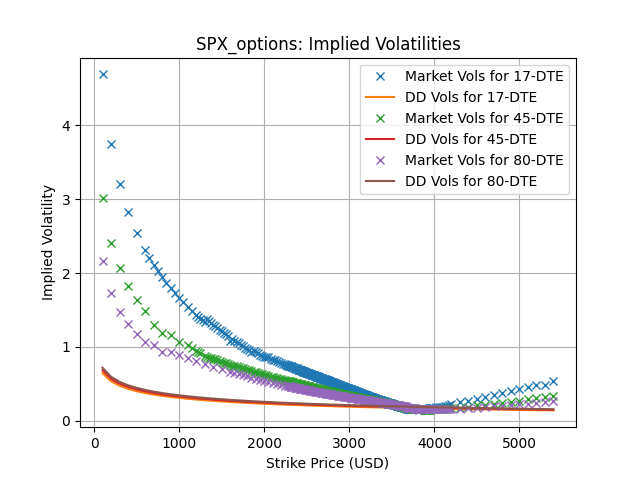

In [53]:
plt.figure()

plt.title("SPX_options: Implied Volatilities")

for day_to_expiry, df_vol in implied_vol_dict_spx.items():

    T = float(day_to_expiry) / 365
    params = SPX_DD_params_by_date[day_to_expiry]
    beta = params["beta"]
    sigma = params["sigma"]

    ddvols = []
    for i, K in enumerate(df_vol["strike"]):
        option_type = df_vol["options_type"][i]
        if option_type == "call":
            price = DisplacedDiffusionCall(
                SPX_spot, K, df_vol["discount_rate"][0], sigma, T, beta
            )
        else:
            price = DisplacedDiffusionPut(
                SPX_spot, K, df_vol["discount_rate"][0], sigma, T, beta
            )
        implied_vol = impliedVolatility(SPX_spot, K, df_vol["discount_rate"][0], price, T, option_type)
        ddvols.append(implied_vol)

    plt.plot(df_vol["strike"], df_vol["impliedvol"], "x", label="Market Vols for {}-DTE".format(day_to_expiry))
    plt.plot(df_vol["strike"], ddvols, label="DD Vols for {}-DTE".format(day_to_expiry))

plt.grid()
plt.xlabel("Strike Price (USD)")
plt.ylabel("Implied Volatility")
plt.legend()
plt.show()

In [54]:
# Initialize the figure
fig = go.Figure()

# Set the title and labels
fig.update_layout(
    title="SPX Options: Implied Volatilities",
    xaxis_title="Strike Price (USD)",
    yaxis_title="Implied Volatility",
    template="plotly_white"
)

# Loop over each day-to-expiry data in the implied volatility dictionary
for day_to_expiry, df_vol in implied_vol_dict_spx.items():
    T = float(day_to_expiry) / 365
    params = SPX_DD_params_by_date[day_to_expiry]
    beta = params["beta"]
    sigma = params["sigma"]

    # Calculate the displaced diffusion implied volatilities
    ddvols = []
    for i, K in enumerate(df_vol["strike"]):
        option_type = df_vol["options_type"][i]
        if option_type == "call":
            price = DisplacedDiffusionCall(
                SPX_spot, K, df_vol["discount_rate"][0], sigma, T, beta
            )
        else:
            price = DisplacedDiffusionPut(
                SPX_spot, K, df_vol["discount_rate"][0], sigma, T, beta
            )
        implied_vol = impliedVolatility(SPX_spot, K, df_vol["discount_rate"][0], price, T, option_type)
        ddvols.append(implied_vol)

    # Add market implied volatilities as scatter points
    fig.add_trace(go.Scatter(
        x=df_vol["strike"], 
        y=df_vol["impliedvol"], 
        mode="markers", 
        name=f"Market Vols for {day_to_expiry}-DTE"
    ))

    # Add displaced diffusion implied volatilities as a line plot
    fig.add_trace(go.Scatter(
        x=df_vol["strike"], 
        y=ddvols, 
        mode="lines", 
        name=f"DD Vols for {day_to_expiry}-DTE"
    ))

# Show the interactive plot
fig.show()

### Displaced Diffusion calibration for SPY

In [55]:
implied_vol_dict_spy.items()

dict_items([('17',      strike  impliedvol options_type  discount_rate  options_price
0      25.0    3.606730          put       0.001255          0.005
1      50.0    2.660929          put       0.001255          0.005
2      75.0    2.120640          put       0.001255          0.005
3      80.0    2.035340          put       0.001255          0.005
4      85.0    1.955363          put       0.001255          0.005
..      ...         ...          ...            ...            ...
250   495.0    0.424099         call       0.001255          0.005
251   500.0    0.437003         call       0.001255          0.005
252   505.0    0.449745         call       0.001255          0.005
253   510.0    0.462328         call       0.001255          0.005
254   515.0    0.474756         call       0.001255          0.005

[255 rows x 5 columns]), ('45',      strike  impliedvol options_type  discount_rate  options_price
0      25.0    2.216993          put       0.002051          0.005
1      30.

In [56]:
SPY_DD_params_by_date = {}

for day_to_expiry, df_vol in implied_vol_dict_spy.items():
    T = float(day_to_expiry) / 365
    spot = SPY_spot
    
    # https://numpy.org/doc/stable/reference/generated/numpy.interp.html
    # This is to estimate the implied volatility (sigma) at the current spot price of the underlying asset (SPX_spot) based on 
    # a known set of implied volatilities (df_vol["impliedvol"]) across different strike prices (df_vol["strike"]). 
    # This serves as an initial estimate of the volatility to be used in further calculations or calibration of the displaced diffusion model. 
    # By interpolating at the SPX_spot level, the code gets a volatility estimate that reflects the market’s current view 
    # of implied volatility near the current price level, which may improve calibration accuracy.
    sigma = np.interp(spot, df_vol["strike"], df_vol["impliedvol"])

    initial_guess = [0.70]  # beta
    res = least_squares(
        lambda x: calculate_DD_vol_err(
                                    x = x,
                                    strikes = df_vol["strike"],
                                    vols = df_vol["impliedvol"],
                                    S = spot,
                                    r = df_vol["discount_rate"][0],
                                    sigma = sigma,
                                    T = T,
                                    options_type = df_vol["options_type"],
                                ),
                                initial_guess,
                                bounds=(0, 1),
    )
    SPY_DD_params_by_date[day_to_expiry] = {"sigma": sigma, "beta": res.x[0]}
SPY_DD_params_by_date

Invalid implied volatility at strike 80.0, option type put
Invalid implied volatility at strike 85.0, option type put
Invalid implied volatility at strike 90.0, option type put
Invalid implied volatility at strike 100.0, option type put
Invalid implied volatility at strike 105.0, option type put
Invalid implied volatility at strike 110.0, option type put
Invalid implied volatility at strike 125.0, option type put
Invalid implied volatility at strike 130.0, option type put
Invalid implied volatility at strike 140.0, option type put
Invalid implied volatility at strike 145.0, option type put
Invalid implied volatility at strike 150.0, option type put
Invalid implied volatility at strike 155.0, option type put
Invalid implied volatility at strike 170.0, option type put
Invalid implied volatility at strike 175.0, option type put
Invalid implied volatility at strike 180.0, option type put
Invalid implied volatility at strike 185.0, option type put
Invalid implied volatility at strike 190.0,

{'17': {'sigma': 0.200905534391913, 'beta': 4.3291743073075643e-07},
 '45': {'sigma': 0.1972176434869465, 'beta': 7.92069950367572e-12},
 '80': {'sigma': 0.2002402677797878, 'beta': 2.0067670573666173e-06}}

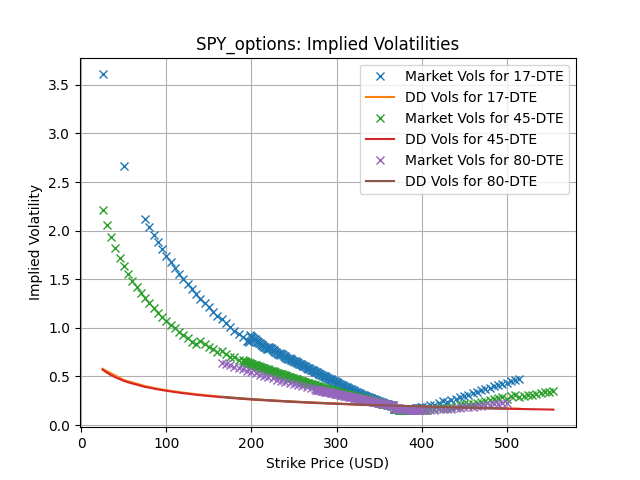

In [57]:
plt.figure()

plt.title("SPY_options: Implied Volatilities")

for day_to_expiry, df_vol in implied_vol_dict_spy.items():

    T = float(day_to_expiry) / 365
    params = SPY_DD_params_by_date[day_to_expiry]
    beta = params["beta"]
    sigma = params["sigma"]

    ddvols = []
    for i, K in enumerate(df_vol["strike"]):
        option_type = df_vol["options_type"][i]
        if option_type == "call":
            price = DisplacedDiffusionCall(
                SPY_spot, K, df_vol["discount_rate"][0], sigma, T, beta
            )
        else:
            price = DisplacedDiffusionPut(
                SPY_spot, K, df_vol["discount_rate"][0], sigma, T, beta
            )
        implied_vol = impliedVolatility(SPY_spot, K, df_vol["discount_rate"][0], price, T, option_type)
        ddvols.append(implied_vol)

    plt.plot(df_vol["strike"], df_vol["impliedvol"], "x", label="Market Vols for {}-DTE".format(day_to_expiry))
    plt.plot(df_vol["strike"], ddvols, label="DD Vols for {}-DTE".format(day_to_expiry))

plt.grid()
plt.xlabel("Strike Price (USD)")
plt.ylabel("Implied Volatility")
plt.legend()
plt.show()

In [58]:
# Initialize the figure
fig = go.Figure()

# Set the title and labels
fig.update_layout(
    title="SPY Options: Implied Volatilities",
    xaxis_title="Strike Price (USD)",
    yaxis_title="Implied Volatility",
    template="plotly_white"
)

# Loop over each day-to-expiry data in the implied volatility dictionary for SPY
for day_to_expiry, df_vol in implied_vol_dict_spy.items():
    T = float(day_to_expiry) / 365
    params = SPY_DD_params_by_date[day_to_expiry]
    beta = params["beta"]
    sigma = params["sigma"]

    # Calculate the displaced diffusion implied volatilities
    ddvols = []
    for i, K in enumerate(df_vol["strike"]):
        option_type = df_vol["options_type"][i]
        if option_type == "call":
            price = DisplacedDiffusionCall(
                SPY_spot, K, df_vol["discount_rate"][0], sigma, T, beta
            )
        else:
            price = DisplacedDiffusionPut(
                SPY_spot, K, df_vol["discount_rate"][0], sigma, T, beta
            )
        implied_vol = impliedVolatility(SPY_spot, K, df_vol["discount_rate"][0], price, T, option_type)
        ddvols.append(implied_vol)

    # Add market implied volatilities as scatter points
    fig.add_trace(go.Scatter(
        x=df_vol["strike"], 
        y=df_vol["impliedvol"], 
        mode="markers", 
        name=f"Market Vols for {day_to_expiry}-DTE"
    ))

    # Add displaced diffusion implied volatilities as a line plot
    fig.add_trace(go.Scatter(
        x=df_vol["strike"], 
        y=ddvols, 
        mode="lines", 
        name=f"DD Vols for {day_to_expiry}-DTE"
    ))

# Show the interactive plot
fig.show()

# SABR calibration

In [59]:
beta = 0.7

In [60]:
def SABR(F, 
         K, 
         T, 
         alpha, 
         beta, 
         rho, 
         nu):
    
    X = K
    # if K is at-the-money-forward
    if abs(F - K) < 1e-12:
        numer1 = (((1 - beta)**2)/24)*alpha*alpha/(F**(2 - 2*beta))
        numer2 = 0.25*rho*beta*nu*alpha/(F**(1 - beta))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        VolAtm = alpha*(1 + (numer1 + numer2 + numer3)*T)/(F**(1-beta))
        sabrsigma = VolAtm
    else:
        z = (nu/alpha)*((F*X)**(0.5*(1-beta)))*np.log(F/X)
        zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
        numer1 = (((1 - beta)**2)/24)*((alpha*alpha)/((F*X)**(1 - beta)))
        numer2 = 0.25*rho*beta*nu*alpha/((F*X)**((1 - beta)/2))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        numer = alpha*(1 + (numer1 + numer2 + numer3)*T)*z
        denom1 = ((1 - beta)**2/24)*(np.log(F/X))**2
        denom2 = (((1 - beta)**4)/1920)*((np.log(F/X))**4)
        denom = ((F*X)**((1 - beta)/2))*(1 + denom1 + denom2)*zhi
        sabrsigma = numer/denom

    return sabrsigma

In [61]:
def sabrcalibration(x, strikes, vols, F, T):
    err = 0.0
    for i, vol in enumerate(vols):
        err += (vol - SABR(F = F, 
                           K = strikes[i], 
                           T = T,
                           alpha = x[0], 
                           beta = beta, 
                           rho = x[1], 
                           nu = x[2]))**2

    return err

### SABR calibration for SPX

In [62]:
SPX_SABR_params_by_date = {}

for day_to_expiry, df_vol in implied_vol_dict_spx.items():

    T = float(day_to_expiry) / 365
    F = SPX_spot * np.exp(df_vol["discount_rate"][0] * T)

    initial_guess = [0.02, 0.2, 0.1]  # alpha, rho, nu
    res = least_squares(
        lambda x: sabrcalibration(
            x, df_vol["strike"], df_vol["impliedvol"], F, T
        ),
        initial_guess,
    )
    SPX_SABR_params_by_date[day_to_expiry] = {
        "F": F,
        "alpha": res.x[0],
        "beta": beta,
        "rho": res.x[1],
        "nu": res.x[2],
    }
SPX_SABR_params_by_date

{'17': {'F': 3662.664084743022,
  'alpha': 1.2122899805313736,
  'beta': 0.7,
  'rho': -0.3009002485424542,
  'nu': 5.459761384395847},
 '45': {'F': 3663.3762493669747,
  'alpha': 1.8165044322089068,
  'beta': 0.7,
  'rho': -0.4043017551686191,
  'nu': 2.790158328184338},
 '80': {'F': 3664.221472703759,
  'alpha': 2.140132608298422,
  'beta': 0.7,
  'rho': -0.5749338867759324,
  'nu': 1.84174697563188}}

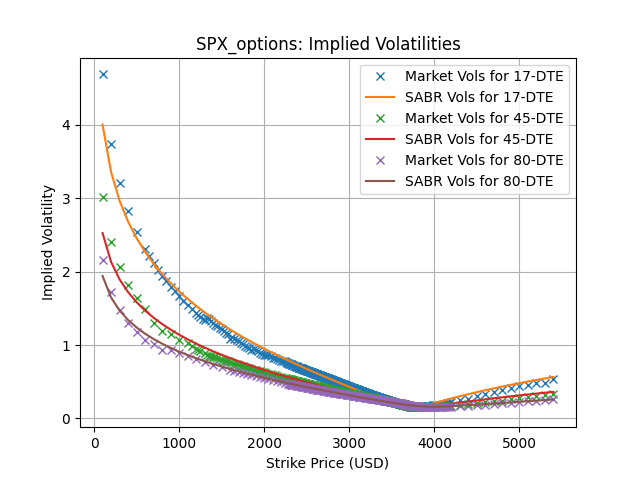

In [63]:
plt.figure()

plt.title("SPX_options: Implied Volatilities")
for day_to_expiry, df_vol in implied_vol_dict_spx.items():
    T = float(day_to_expiry) / 365
    F = SPX_spot * np.exp(df_vol["discount_rate"][0] * T)
    params = SPX_SABR_params_by_date[day_to_expiry]

    sabrvols = []
    for K in df_vol["strike"]:
        sabrvols.append(
            SABR(F, K, T, params["alpha"], beta, params["rho"], params["nu"])
        )
    plt.plot(df_vol["strike"], df_vol["impliedvol"], "x", label="Market Vols for {}-DTE".format(day_to_expiry))
    plt.plot(df_vol["strike"], sabrvols, label="SABR Vols for {}-DTE".format(day_to_expiry))

plt.grid()
plt.xlabel("Strike Price (USD)")
plt.ylabel("Implied Volatility")
plt.legend()
plt.show()

In [64]:
# Initialize the figure
fig = go.Figure()

# Title for the plot
fig.update_layout(title="SPX_options: Implied Volatilities for {}-DTE".format(day_to_expiry))

# Iterate over each DTE and plot both market and SABR vols
for day_to_expiry, df_vol in implied_vol_dict_spx.items():
    T = float(day_to_expiry) / 365
    F = SPX_spot * np.exp(df_vol["discount_rate"][0] * T)
    params = SPX_SABR_params_by_date[day_to_expiry]

    # Calculate SABR volatilities
    sabrvols = [SABR(F, 
                     K, 
                     T, 
                     params["alpha"], 
                     beta, 
                     params["rho"], 
                     params["nu"]) 
                for K in df_vol["strike"]]

    # Add scatter plot for market vols
    fig.add_trace(go.Scatter(
        x=df_vol["strike"],
        y=df_vol["impliedvol"],
        mode='markers',
        name="Market Vols for {}-DTE".format(day_to_expiry),
        marker=dict(symbol="x")
    ))

    # Add line plot for SABR vols
    fig.add_trace(go.Scatter(
        x=df_vol["strike"],
        y=sabrvols,
        mode='lines',
        name="SABR Vols for {}-DTE".format(day_to_expiry)
    ))

# Update layout for grid, axis labels, and legend
fig.update_layout(
    xaxis_title="Strike Price (USD)",
    yaxis_title="Implied Volatility",
    showlegend=True,
    xaxis=dict(showgrid=True),
    yaxis=dict(showgrid=True)
)

# Show the Plotly figure
fig.show()

### SABR calibration for SPY

In [65]:
SPY_SABR_params_by_date = {}

for day_to_expiry, df_vol in implied_vol_dict_spy.items():

    T = float(day_to_expiry) / 365
    F = SPY_spot * np.exp(df_vol["discount_rate"][0] * T)

    initial_guess = [0.02, 0.2, 0.1]  # alpha, rho, nu
    res = least_squares(
        lambda x: sabrcalibration(
            x, df_vol["strike"], df_vol["impliedvol"], F, T
        ),
        initial_guess,
    )
    SPY_SABR_params_by_date[day_to_expiry] = {
        "F": F,
        "alpha": res.x[0],
        "beta": beta,
        "rho": res.x[1],
        "nu": res.x[2],
    }
SPY_SABR_params_by_date

{'17': {'F': 366.0413953221589,
  'alpha': 0.6654021853245597,
  'beta': 0.7,
  'rho': -0.4118998606736283,
  'nu': 5.249981439124839},
 '45': {'F': 366.11256803322914,
  'alpha': 0.9081326349323565,
  'beta': 0.7,
  'rho': -0.4887794472282475,
  'nu': 2.72851634129598},
 '80': {'F': 366.1970384412155,
  'alpha': 1.1209243559875335,
  'beta': 0.7,
  'rho': -0.6329391710914177,
  'nu': 1.742224768224667}}

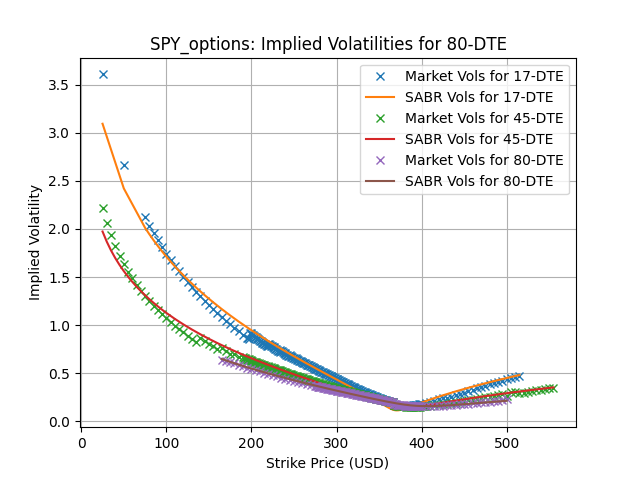

In [66]:
plt.figure()

plt.title("SPY_options: Implied Volatilities for {}-DTE".format(day_to_expiry))
for day_to_expiry, df_vol in implied_vol_dict_spy.items():
    T = float(day_to_expiry) / 365
    F = SPY_spot * np.exp(df_vol["discount_rate"][0] * T)
    params = SPY_SABR_params_by_date[day_to_expiry]

    sabrvols = []
    for K in df_vol["strike"]:
        sabrvols.append(
            SABR(F, K, T, params["alpha"], beta, params["rho"], params["nu"])
        )
    plt.plot(df_vol["strike"], df_vol["impliedvol"], "x", label="Market Vols for {}-DTE".format(day_to_expiry))
    plt.plot(df_vol["strike"], sabrvols, label="SABR Vols for {}-DTE".format(day_to_expiry))

plt.grid()
plt.xlabel("Strike Price (USD)")
plt.ylabel("Implied Volatility")
plt.legend()
plt.show()

In [67]:
# Initialize the figure
fig = go.Figure()

# Title for the plot
fig.update_layout(title="SPY_options: Implied Volatilities for {}-DTE".format(day_to_expiry))

# Iterate over each DTE and plot both market and SABR vols
for day_to_expiry, df_vol in implied_vol_dict_spy.items():
    T = float(day_to_expiry) / 365
    F = SPY_spot * np.exp(df_vol["discount_rate"][0] * T)
    params = SPY_SABR_params_by_date[day_to_expiry]

    # Calculate SABR volatilities
    sabrvols = [SABR(F, 
                     K, 
                     T, 
                     params["alpha"], 
                     beta, 
                     params["rho"], 
                     params["nu"]) 
                for K in df_vol["strike"]]

    # Add scatter plot for market vols
    fig.add_trace(go.Scatter(
        x=df_vol["strike"],
        y=df_vol["impliedvol"],
        mode='markers',
        name="Market Vols for {}-DTE".format(day_to_expiry),
        marker=dict(symbol="x")
    ))

    # Add line plot for SABR vols
    fig.add_trace(go.Scatter(
        x=df_vol["strike"],
        y=sabrvols,
        mode='lines',
        name="SABR Vols for {}-DTE".format(day_to_expiry)
    ))

# Update layout for grid, axis labels, and legend
fig.update_layout(
    xaxis_title="Strike Price (USD)",
    yaxis_title="Implied Volatility",
    showlegend=True,
    xaxis=dict(showgrid=True),
    yaxis=dict(showgrid=True)
)

# Show the Plotly figure
fig.show()

# Implied Volatility

In [68]:
def BlackScholesCall(S0:float, 
                     K:float, 
                     r:float, 
                     sigma:float, 
                     T:float):
    
    d1 = (np.log(S0/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    
    d2 = d1 - sigma*np.sqrt(T)
    
    value = S0*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)
    
    return value

In [69]:
def BlackScholesPut(S0:float, 
                     K:float, 
                     r:float, 
                     sigma:float, 
                     T:float):
    
    d1 = (np.log(S0/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    
    d2 = d1 - sigma*np.sqrt(T)
    
    value = K*np.exp(-r*T)*norm.cdf(-d2) - S0*norm.cdf(-d1)
    
    return value

In [70]:
def implied_Volatility(S0, 
                       K, 
                       r, 
                       price, 
                       T, 
                       payoff):
    
    try:
        if (payoff.lower() == 'call'):
            impliedVol = brentq(lambda x: price -
                                BlackScholesCall(S0, K, r, x, T),
                                1e-12, 10.0)
        elif (payoff.lower() == 'put'):
            impliedVol = brentq(lambda x: price -
                                BlackScholesPut(S0, K, r, x, T),
                                1e-12, 10.0)
        else:
            raise NameError('Payoff type not recognized')
    except Exception:
        impliedVol = np.nan

    return impliedVol

In [71]:
def compute_implied_volatility_for(df_options, 
                                   current_price):
    
    S = current_price

    df_filtered = df_options

    df_filtered["implied_vol"] = df_filtered.apply(
        lambda x: implied_Volatility(
            S0=S,
            K=x["strike_price"],
            r=x["rate_decimal"],
            price=x["mid_price"],
            T=x["years_to_expiry"],
            payoff=x["options_type"],
        ),
        axis=1,
    )
    df_filtered.dropna(inplace=True)

    return df_filtered

In [72]:
implied_vol_spx = compute_implied_volatility_for(SPX_df, SPX_spot)
implied_vol_spy = compute_implied_volatility_for(SPY_df, SPY_spot)

In [73]:
implied_vol_spx

,date,exdate,cp_flag,strike_price,best_bid,best_offer,exercise_style,days_to_expiry,years_to_expiry,mid_price,options_type,rate,rate_decimal,implied_vol
198,2020-12-01,2020-12-18,C,3005.0,653.5,661.9,E,17.0,0.046575,657.70,call,0.125500,0.001255,0.302638
201,2020-12-01,2020-12-18,C,3020.0,638.5,647.0,E,17.0,0.046575,642.75,call,0.125500,0.001255,0.309125
204,2020-12-01,2020-12-18,C,3035.0,623.7,632.1,E,17.0,0.046575,627.90,call,0.125500,0.001255,0.326027
207,2020-12-01,2020-12-18,C,3050.0,608.9,617.2,E,17.0,0.046575,613.05,call,0.125500,0.001255,0.333562
210,2020-12-01,2020-12-18,C,3065.0,593.9,602.3,E,17.0,0.046575,598.10,call,0.125500,0.001255,0.329596
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2067,2020-12-01,2021-02-19,P,5000.0,1333.1,1350.5,E,80.0,0.219178,1341.80,put,0.220628,0.002206,0.341058
2068,2020-12-01,2021-02-19,P,5100.0,1431.8,1454.7,E,80.0,0.219178,1443.25,put,0.220628,0.002206,0.370768
2069,2020-12-01,2021-02-19,P,5200.0,1531.7,1554.6,E,80.0,0.219178,1543.15,put,0.220628,0.002206,0.387810
2070,2020-12-01,2021-02-19,P,5300.0,1631.5,1654.4,E,80.0,0.219178,1642.95,put,0.220628,0.002206,0.403519


In [74]:
implied_vol_spy

,date,exdate,cp_flag,strike_price,best_bid,best_offer,exercise_style,days_to_expiry,years_to_expiry,mid_price,options_type,rate,rate_decimal,implied_vol
55,2020-12-01,2020-12-18,C,224.0,141.81,142.26,A,17.0,0.046575,142.035,call,0.125500,0.001255,0.641332
56,2020-12-01,2020-12-18,C,225.0,140.81,141.26,A,17.0,0.046575,141.035,call,0.125500,0.001255,0.634506
57,2020-12-01,2020-12-18,C,226.0,139.81,140.26,A,17.0,0.046575,140.035,call,0.125500,0.001255,0.627690
58,2020-12-01,2020-12-18,C,227.0,138.81,139.26,A,17.0,0.046575,139.035,call,0.125500,0.001255,0.620882
59,2020-12-01,2020-12-18,C,228.0,137.81,138.26,A,17.0,0.046575,138.035,call,0.125500,0.001255,0.614080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,2020-12-01,2021-02-19,P,480.0,115.03,115.93,A,80.0,0.219178,115.480,put,0.220628,0.002206,0.365322
1396,2020-12-01,2021-02-19,P,485.0,120.08,120.92,A,80.0,0.219178,120.500,put,0.220628,0.002206,0.376933
1397,2020-12-01,2021-02-19,P,490.0,125.07,125.92,A,80.0,0.219178,125.495,put,0.220628,0.002206,0.387244
1398,2020-12-01,2021-02-19,P,495.0,129.98,130.92,A,80.0,0.219178,130.450,put,0.220628,0.002206,0.395489


In [75]:
SPX_df

,date,exdate,cp_flag,strike_price,best_bid,best_offer,exercise_style,days_to_expiry,years_to_expiry,mid_price,options_type,rate,rate_decimal,implied_vol
198,2020-12-01,2020-12-18,C,3005.0,653.5,661.9,E,17.0,0.046575,657.70,call,0.125500,0.001255,0.302638
201,2020-12-01,2020-12-18,C,3020.0,638.5,647.0,E,17.0,0.046575,642.75,call,0.125500,0.001255,0.309125
204,2020-12-01,2020-12-18,C,3035.0,623.7,632.1,E,17.0,0.046575,627.90,call,0.125500,0.001255,0.326027
207,2020-12-01,2020-12-18,C,3050.0,608.9,617.2,E,17.0,0.046575,613.05,call,0.125500,0.001255,0.333562
210,2020-12-01,2020-12-18,C,3065.0,593.9,602.3,E,17.0,0.046575,598.10,call,0.125500,0.001255,0.329596
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2067,2020-12-01,2021-02-19,P,5000.0,1333.1,1350.5,E,80.0,0.219178,1341.80,put,0.220628,0.002206,0.341058
2068,2020-12-01,2021-02-19,P,5100.0,1431.8,1454.7,E,80.0,0.219178,1443.25,put,0.220628,0.002206,0.370768
2069,2020-12-01,2021-02-19,P,5200.0,1531.7,1554.6,E,80.0,0.219178,1543.15,put,0.220628,0.002206,0.387810
2070,2020-12-01,2021-02-19,P,5300.0,1631.5,1654.4,E,80.0,0.219178,1642.95,put,0.220628,0.002206,0.403519


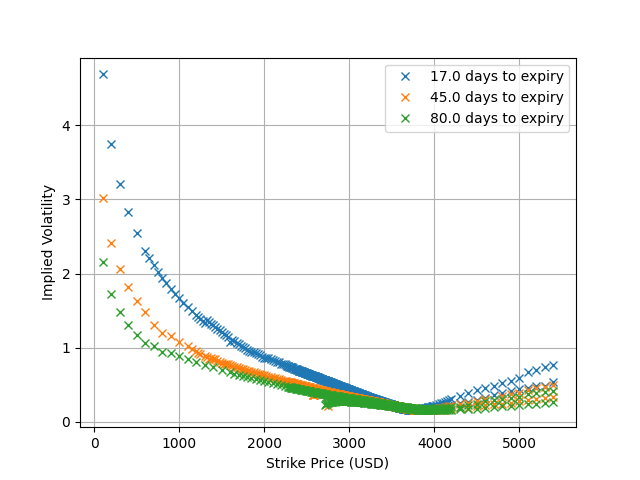

In [76]:
plt.figure()  # Start a new figure

for expiry in SPX_df["days_to_expiry"].unique():
    subset = SPX_df[SPX_df["days_to_expiry"] == expiry]
    plt.plot(
        subset["strike_price"],
        subset["implied_vol"],
        "x",
        label=f"{expiry} days to expiry"
    )

plt.grid()
plt.xlabel("Strike Price (USD)")
plt.ylabel("Implied Volatility")
plt.legend()
plt.show()

In [77]:
# Create an empty figure
fig = go.Figure()

# Loop through unique 'days_to_expiry' and add traces for each
for expiry in SPX_df["days_to_expiry"].unique():
    subset = SPX_df[SPX_df["days_to_expiry"] == expiry]
    
    # Add a scatter trace for each subset
    fig.add_trace(go.Scatter(
        x=subset["strike_price"],
        y=subset["implied_vol"],
        mode='markers',
        name=f"{expiry} days to expiry"
    ))

# Add labels and grid
fig.update_layout(
    xaxis_title="Strike Price (USD)",
    yaxis_title="Implied Volatility",
    title="Strike Price vs Implied Volatility",
    showlegend=True
)

# Show the plot
fig.show()


In [78]:
SPY_df

,date,exdate,cp_flag,strike_price,best_bid,best_offer,exercise_style,days_to_expiry,years_to_expiry,mid_price,options_type,rate,rate_decimal,implied_vol
55,2020-12-01,2020-12-18,C,224.0,141.81,142.26,A,17.0,0.046575,142.035,call,0.125500,0.001255,0.641332
56,2020-12-01,2020-12-18,C,225.0,140.81,141.26,A,17.0,0.046575,141.035,call,0.125500,0.001255,0.634506
57,2020-12-01,2020-12-18,C,226.0,139.81,140.26,A,17.0,0.046575,140.035,call,0.125500,0.001255,0.627690
58,2020-12-01,2020-12-18,C,227.0,138.81,139.26,A,17.0,0.046575,139.035,call,0.125500,0.001255,0.620882
59,2020-12-01,2020-12-18,C,228.0,137.81,138.26,A,17.0,0.046575,138.035,call,0.125500,0.001255,0.614080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,2020-12-01,2021-02-19,P,480.0,115.03,115.93,A,80.0,0.219178,115.480,put,0.220628,0.002206,0.365322
1396,2020-12-01,2021-02-19,P,485.0,120.08,120.92,A,80.0,0.219178,120.500,put,0.220628,0.002206,0.376933
1397,2020-12-01,2021-02-19,P,490.0,125.07,125.92,A,80.0,0.219178,125.495,put,0.220628,0.002206,0.387244
1398,2020-12-01,2021-02-19,P,495.0,129.98,130.92,A,80.0,0.219178,130.450,put,0.220628,0.002206,0.395489


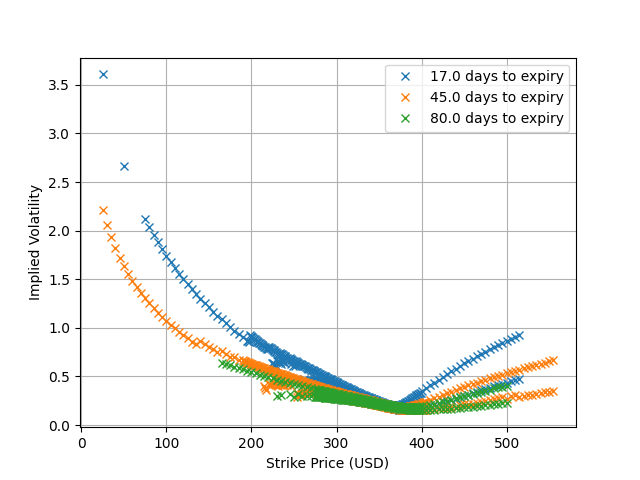

In [79]:
plt.figure()  # Start a new figure

plt.plot()
for expiry in SPY_df["days_to_expiry"].unique():
    subset = SPY_df[SPY_df["days_to_expiry"] == expiry]
    plt.plot(
        subset["strike_price"],
        subset["implied_vol"],
        "x",
        label=f"{expiry} days to expiry"
    )

plt.grid()
plt.xlabel("Strike Price (USD)")
plt.ylabel("Implied Volatility")
plt.legend()
plt.show()

In [80]:
# Create an empty figure
fig = go.Figure()

# Loop through unique 'days_to_expiry' and add traces for each
for expiry in SPY_df["days_to_expiry"].unique():
    subset = SPY_df[SPY_df["days_to_expiry"] == expiry]
    
    # Add a scatter trace for each subset
    fig.add_trace(go.Scatter(
        x=subset["strike_price"],
        y=subset["implied_vol"],
        mode='markers',
        name=f"{expiry} days to expiry"
    ))

# Add labels and grid
fig.update_layout(
    xaxis_title="Strike Price (USD)",
    yaxis_title="Implied Volatility",
    title="Strike Price vs Implied Volatility",
    showlegend=True
)

# Show the plot
fig.show()

# Displaced-diffusion model

In [81]:
def DisplacedDiffusionCall(S0:float, 
                           K:float, 
                           r:float, 
                           sigma:float, 
                           T:float,
                           beta:float):
    
    F0 = np.exp(r*T)*S0
    
    # From Session 6, slide 14
    DD_FO=F0/beta
    
    DD_K=K+((1-beta)/beta)*F0
    
    DD_sigma=sigma*beta
    
    # Refer to last line in Session 5, slide 16. This is NOT the same d1 used in BlackScholes
    d1 = (np.log(DD_FO/DD_K) + 0.5 * (DD_sigma**2) * T) / (DD_sigma*np.sqrt(T))
    
    d2 = d1 - DD_sigma * np.sqrt(T)
    
    # Last line in Session 5, slide 16
    value = np.exp(-r*T) * (DD_FO * norm.cdf(d1) - DD_K * norm.cdf(d2))
    
    return value

In [82]:
def DisplacedDiffusionPut(S0:float, 
                          K:float, 
                          r:float, 
                          sigma:float, 
                          T:float,
                          beta:float):
    
    F0 = np.exp(r*T)*S0
    
    # From Session 6, slide 14
    DD_F0=F0/beta
    
    DD_K=K+((1-beta)/beta)*F0
    
    DD_sigma=sigma*beta
    
    # Refer to last line in Session 5, slide 16. This is NOT the same d1 used in BlackScholes
    d1 = (np.log(DD_F0/DD_K) + 0.5 * (DD_sigma**2) * T) / (DD_sigma*np.sqrt(T))
    
    d2 = d1 - DD_sigma * np.sqrt(T)
    
    # Last line in Session 5,slide 16, but order is flipped, just like BlackScholes put
    value = np.exp(-r*T) * (DD_K * norm.cdf(-d2) - DD_F0 * norm.cdf(-d1))
    
    return value

In [83]:
def calculate_DD_vol_err(x, 
                         strikes, 
                         vols, 
                         S0, 
                         r, 
                         sigma, 
                         T, 
                         options_type):
    
    err = 0.0
    for i, vol in enumerate(vols):
        if options_type[i] == "call":
            price = DisplacedDiffusionCall(S0 = S0, 
                                           K = strikes[i], 
                                           r = r, 
                                           sigma = sigma, 
                                           T = T, 
                                           beta = x[0])
        else:
            price = DisplacedDiffusionPut(S0 = S0, 
                                           K = strikes[i], 
                                           r = r, 
                                           sigma = sigma, 
                                           T = T, 
                                           beta = x[0])
            
        implied_vol = implied_Volatility(S0 = S0, 
                                         K = strikes[i], 
                                         r = r, 
                                         price = price, 
                                         T = T, 
                                         payoff = options_type[i])
        if not np.isfinite(implied_vol):
            print(f"Invalid implied volatility at strike {strikes[i]}, option type {options_type[i]}")
        
        err += (vol - implied_vol) ** 2
    return err

In [84]:
SPY_df

,date,exdate,cp_flag,strike_price,best_bid,best_offer,exercise_style,days_to_expiry,years_to_expiry,mid_price,options_type,rate,rate_decimal,implied_vol
55,2020-12-01,2020-12-18,C,224.0,141.81,142.26,A,17.0,0.046575,142.035,call,0.125500,0.001255,0.641332
56,2020-12-01,2020-12-18,C,225.0,140.81,141.26,A,17.0,0.046575,141.035,call,0.125500,0.001255,0.634506
57,2020-12-01,2020-12-18,C,226.0,139.81,140.26,A,17.0,0.046575,140.035,call,0.125500,0.001255,0.627690
58,2020-12-01,2020-12-18,C,227.0,138.81,139.26,A,17.0,0.046575,139.035,call,0.125500,0.001255,0.620882
59,2020-12-01,2020-12-18,C,228.0,137.81,138.26,A,17.0,0.046575,138.035,call,0.125500,0.001255,0.614080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,2020-12-01,2021-02-19,P,480.0,115.03,115.93,A,80.0,0.219178,115.480,put,0.220628,0.002206,0.365322
1396,2020-12-01,2021-02-19,P,485.0,120.08,120.92,A,80.0,0.219178,120.500,put,0.220628,0.002206,0.376933
1397,2020-12-01,2021-02-19,P,490.0,125.07,125.92,A,80.0,0.219178,125.495,put,0.220628,0.002206,0.387244
1398,2020-12-01,2021-02-19,P,495.0,129.98,130.92,A,80.0,0.219178,130.450,put,0.220628,0.002206,0.395489


In [85]:
# Loop through unique 'days_to_expiry'
for expiry in SPY_df["days_to_expiry"].unique():
    df_vol = SPY_df[SPY_df["days_to_expiry"] == expiry].reset_index(drop=True)
    print(df_vol)

          date     exdate cp_flag  strike_price  best_bid  best_offer  \
0   2020-12-01 2020-12-18       C         224.0    141.81      142.26   
1   2020-12-01 2020-12-18       C         225.0    140.81      141.26   
2   2020-12-01 2020-12-18       C         226.0    139.81      140.26   
3   2020-12-01 2020-12-18       C         227.0    138.81      139.26   
4   2020-12-01 2020-12-18       C         228.0    137.81      138.26   
..         ...        ...     ...           ...       ...         ...   
427 2020-12-01 2020-12-18       P         495.0    130.25      130.71   
428 2020-12-01 2020-12-18       P         500.0    135.25      135.71   
429 2020-12-01 2020-12-18       P         505.0    140.25      140.70   
430 2020-12-01 2020-12-18       P         510.0    145.25      145.70   
431 2020-12-01 2020-12-18       P         515.0    150.25      150.70   

    exercise_style  days_to_expiry  years_to_expiry  mid_price options_type  \
0                A            17.0         0

In [86]:
# Loop through unique 'days_to_expiry'
for expiry in SPY_df["days_to_expiry"].unique():
    df_vol = SPY_df[SPY_df["days_to_expiry"] == expiry].reset_index(drop=True)

    # Interpolate implied volatility based on current spot price
    sigma = np.interp(SPY_spot, df_vol["strike_price"], df_vol["implied_vol"])

    # Initial guess for beta
    initial_guess = [0.96]  # Adjust this based on your assumptions

    # Perform least squares optimization to find beta
    res = least_squares(
        lambda x: calculate_DD_vol_err(
            x = x,
            strikes = df_vol["strike_price"], 
            vols = df_vol["implied_vol"],
            S0 = SPY_spot,
            r = df_vol["rate_decimal"][0],  
            sigma = sigma,
            T = df_vol["years_to_expiry"][0],  
            options_type = df_vol["options_type"]
        ),
        initial_guess,
        bounds=(0, 1)  # Adjust bounds based on your domain knowledge
    )
    
    print(f"For {expiry} days to expiry, Sigma is {sigma} and Beta is {res.x[0]}")

Invalid implied volatility at strike 224.0, option type call
Invalid implied volatility at strike 225.0, option type call
Invalid implied volatility at strike 226.0, option type call
Invalid implied volatility at strike 227.0, option type call
Invalid implied volatility at strike 228.0, option type call
Invalid implied volatility at strike 229.0, option type call
Invalid implied volatility at strike 230.0, option type call
Invalid implied volatility at strike 231.0, option type call
Invalid implied volatility at strike 232.0, option type call
Invalid implied volatility at strike 233.0, option type call
Invalid implied volatility at strike 234.0, option type call
Invalid implied volatility at strike 235.0, option type call
Invalid implied volatility at strike 236.0, option type call
Invalid implied volatility at strike 237.0, option type call
Invalid implied volatility at strike 239.0, option type call
Invalid implied volatility at strike 247.0, option type call
Invalid implied volatili

ValueError: Residuals are not finite in the initial point.